In [1]:
!jupyter nbconvert --to script pack_existing_segs.ipynb --output pack_existing_segs
from pack_existing_segs import *

[NbConvertApp] Converting notebook pack_existing_segs.ipynb to script
[NbConvertApp] Writing 1722 bytes to pack_existing_segs.py


In [2]:
import pickle
from enum import Enum
from IPython import display

import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces

from torchvision.models import resnet50
import numpy as np
from torchvision import transforms
import os
import glob
from PIL import Image
import PIL
import json
from pathlib import Path
import tianshou as ts
from gymnasium.wrappers import TimeLimit
import einops
from transformers import ViTImageProcessor, ViTModel

/home/behnamnia/.conda/envs/rl39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/behnamnia/.conda/envs/rl39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
if __name__ == '__main__':
    torch.multiprocessing.set_start_method('spawn')

## Dataset

In [4]:
class COCODataset(D.Dataset):
    def __init__(self, root, train=True):
        self.root = Path(root)

        with open(self.root/'annotations/captions_train2017.json', 'r') as f:
            images_info = json.load(f)
        self.file_name_to_id = dict()
        for image_info in images_info['images']:
            self.file_name_to_id[image_info['file_name']] = image_info['id']

        with open(self.root/'cap_dict.json', 'r') as f:
            self.captions_dict = json.load(f)

        if train:
            self.image_files = glob.glob(os.path.join(self.root/'train2017', "*.jpg"))
        else:
            self.image_files = glob.glob(os.path.join(self.root/'val2017', "*.jpg"))

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image = PIL.Image.open(image_file)
        image = image.convert('RGB')
        file_name = image_file.split('/')[-1]
        image_tensor = transforms.ToTensor()(image)

        return image_tensor, self.file_name_to_id[file_name]

    def __len__(self):
        return len(self.image_files)

In [5]:
class COCODatasetSegFirst(D.Dataset):
    def __init__(self, root, train=True, len=-1):
        self.root = Path(root)

        with open(self.root/'annotations/captions_train2017.json', 'r') as f:
            images_info = json.load(f)
        self.file_name_to_id = dict()
        for image_info in images_info['images']:
            self.file_name_to_id[image_info['file_name']] = image_info['id']
            self.file_name_to_id[image_info['id']] = image_info['file_name'] # for reverse search

        with open(self.root/'cap_dict.json', 'r') as f:
            self.captions_dict = json.load(f)

        self.seg_files = glob.glob(os.path.join(self.root/'train2017seg', "*.pkl"))
        if len != -1:
            self.seg_files = random.sample(self.seg_files, len)

    def __getitem__(self, index):
        seg_file = self.seg_files[index]
        file_id = int(seg_file.split('/')[-1].split('.')[0])
        image_file = self.root/'train2017'/self.file_name_to_id[file_id]
        image = PIL.Image.open(image_file)
        image = image.convert('RGB')
        image_tensor = transforms.ToTensor()(image)

        return image_tensor, file_id

    def __len__(self):
        return len(self.seg_files)

## Environment

In [7]:
class Actions(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3
    # STAY = 4

In [14]:
class History:
    def __init__(self, patch_size, max_row=None, max_col=None):
        self.patch_size = patch_size
        if max_row is None:
            self._min_row, self._min_col, self._max_row, self._max_col = None, None, None, None
            self.pos_mask = None
            self.history = None
        else:
            self._min_row, self._min_col, self._max_row, self._max_col = 0, 0, max_row, max_col
            self.pos_mask = torch.ones((max_row*patch_size[0], max_col*patch_size[1]))
            self.history = torch.zeros((3, max_row*patch_size[0], max_col*patch_size[1]))
            print(self.pos_mask.shape, self.history.shape)

        self.curr_rel_row, self.curr_rel_col = None, None


    def append(self, patch, row, col):
        if self._min_row is None:
            self._min_row, self._min_col, self._max_row, self._max_col = row, col, row, col
            self.history = patch
            self.pos_mask = torch.ones(patch.shape[1:])
        else:
            if row < self._min_row:
                # pad history with zeros on top to account for row difference
                self.history = torch.cat((torch.zeros(3, self.patch_size[0] * (self._min_row - row), self.history.shape[2]), self.history), dim=1)
                self.pos_mask = torch.cat((torch.ones(self.patch_size[0] * (self._min_row - row), self.history.shape[2]), self.pos_mask), dim=0)
                self._min_row = row
            if row > self._max_row:
                # pad history with zeros on bottom to account for row difference
                self.history = torch.cat((self.history, torch.zeros(3, self.patch_size[0] * (row - self._max_row), self.history.shape[2])), dim=1)
                self.pos_mask = torch.cat((self.pos_mask, torch.ones(self.patch_size[0] * (row - self._max_row), self.history.shape[2])), dim=0)
                self._max_row = row
            if col < self._min_col:
                # pad history with zeros on left to account for col difference
                self.history = torch.cat((torch.zeros(3, self.history.shape[1], self.patch_size[1] * (self._min_col - col)), self.history), dim=2)
                self.pos_mask = torch.cat((torch.ones(self.history.shape[1], self.patch_size[1] * (self._min_col - col)), self.pos_mask), dim=1)
                self._min_col = col
            if col > self._max_col:
                # pad history with zeros on right to account for col difference
                self.history = torch.cat((self.history, torch.zeros(3, self.history.shape[1], self.patch_size[1] * (col - self._max_col))), dim=2)
                self.pos_mask = torch.cat((self.pos_mask, torch.ones(self.history.shape[1], self.patch_size[1] * (col - self._max_col))), dim=1)
                self._max_col = col
            # add patch to history
            top = self.patch_size[0] * (row - self._min_row)
            bottom = top + self.patch_size[0]
            left = self.patch_size[1] * (col - self._min_col)
            right = left + self.patch_size[1]

            self.history[:, top:bottom, left:right] = patch
            self.pos_mask[top:bottom, left:right] = 0
        self.curr_rel_col = col - self._min_col
        self.curr_rel_row = row - self._min_row

In [15]:
class Environment(gym.Env):
    metadata = {"render_modes": ["rgb_array"], "render_fps": 4}

    def __init__(self, dataloader, patch_size=(64, 64), input_size=224):
        self.dataloader = dataloader
        self.iterator = iter(dataloader)
        self.transform = transforms.Resize(input_size)
        self.patch_size = patch_size

        self.observation_space = spaces.Dict({
            'center': spaces.Box(low=0, high=255, shape=(3, self.patch_size[0], self.patch_size[1]), dtype=np.uint8),
            'surrounding': spaces.Box(low=0, high=255, shape=(3, self.patch_size[0], self.patch_size[1]), dtype=np.uint8),
        })
        self.action_space = spaces.Discrete(len(Actions))

        self.reset()

    def reset(self, **kwargs):
        try:
            # Samples the batch
            self.current_image, self.image_id = next(self.iterator)
        except StopIteration:
            # restart the iterator if the previous iterator is exhausted.
            self.iterator = iter(self.dataloader)
            self.current_image, self.image_id = next(self.iterator)

        self.current_image = self.current_image
        self.image_id = str(self.image_id.item())
        _, _, self.height, self.width = self.current_image.shape
        self.captions = self.dataloader.dataset.captions_dict[self.image_id]
        self.max_row, self.max_col = (self.height - self.patch_size[0]) // self.patch_size[0], (self.width - self.patch_size[1]) // self.patch_size[1]

        # self.row, self.col = [int(x) for x in self.grad(self.transform(self.current_image.to(device)), self.height, self.width)[0]] # just a single row/col
        self.row, self.col = self.max_row//2, self.max_col//2

        self.seg_output = None
        self.seen_patches = torch.zeros((self.max_row + 1, self.max_col + 1))
        # self.history = History(self.patch_size)
        self.history = History(self.patch_size, self.max_row, self.max_col)

        return self._get_obs(), {}

    def _get_patch(self):
        start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
        start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]
        return self.current_image[0, :, start_row: end_row, start_col: end_col]

    def _get_history(self, new_patch):
        self.history.append(new_patch, self.row, self.col)
        return self.history

    def _get_obs(self):
        patch = self._get_patch()
        history = self._get_history(patch)
        return {
            # 'center': patch,
            # 'surrounding': self._get_surrounding(),
            'history': {
                'history': history.history,
                'pos_mask': history.pos_mask,
                'curr_rel_row': history.curr_rel_row,
                'curr_rel_col': history.curr_rel_col,
                'patch_size': history.patch_size,
            }
        }

    def _get_surrounding(self):
        # get surrounding area and pad with zero on the corresponding side that is out of bound
        surrounding = torch.zeros((3, 3*self.patch_size[0], 3*self.patch_size[1]))
        target_start_row = self.patch_size[0] if self.row == 0 else 0
        target_end_row = 2*self.patch_size[0] if self.row == self.max_row else 3*self.patch_size[0]
        target_start_col = self.patch_size[1] if self.col == 0 else 0
        target_end_col = 2*self.patch_size[1] if self.col == self.max_col else 3*self.patch_size[1]
        start_row = max(0, self.row - 1) * self.patch_size[0]
        end_row = min(self.max_row + 1, self.row + 2) * self.patch_size[0]
        start_col = max(0, self.col - 1) * self.patch_size[1]
        end_col = min(self.max_col + 1, self.col + 2) * self.patch_size[1]
        surrounding[:, target_start_row: target_end_row, target_start_col: target_end_col] = self.current_image[0, :, start_row: end_row, start_col: end_col]
        # resize surrounding to match the patch size
        surrounding = transforms.Resize(self.patch_size)(surrounding)
        return surrounding

    def _reward_seg(self):
        if self.seg_output is None:
            dataset = self.dataloader.dataset
            # open image_id with .pkl extension and dataset.root as the root directory
            with open(dataset.root / 'train2017seg' / (self.image_id + '.pkl'), 'rb') as f:
                packed_seg_out = pickle.load(f)
            self.seg_output = unpack_new_seg_out(packed_seg_out)
            self.seg_output = torch.from_numpy(self.seg_output).to(device)
            self.seen_masks = torch.zeros(self.seg_output.shape[0]).to(device)

        start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
        start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]
        patch_seg = self.seg_output[:, start_row: end_row, start_col: end_col]
        patch_seg = patch_seg.sum(dim=(1, 2)) / self.seg_output.sum(dim=(1, 2))
        seen_threshold = 0.9
        seg_reward = (patch_seg > seen_threshold)
        seg_reward = seg_reward * (1 - self.seen_masks)
        self.seen_masks += seg_reward
        seg_reward = seg_reward.sum().item()

        return seg_reward

    def _reward_return(self):
        reward = -self.seen_patches[self.row, self.col]
        self.seen_patches[self.row, self.col] = 1
        return reward

    def step(self, action):
        if Actions(action) == Actions.UP:
            self.row = self.row - 1 if self.row > 0 else self.row
        elif Actions(action) == Actions.RIGHT:
            self.col = self.col + 1 if self.col < self.max_col else self.col
        elif Actions(action) == Actions.DOWN:
            self.row = self.row + 1 if self.row < self.max_row else self.row
        elif Actions(action) == Actions.LEFT:
            self.col = self.col - 1 if self.col > 0 else self.col
        else:
            raise ValueError("Invalid action")

        obs = self._get_obs()
        reward = self._reward_seg() + self._reward_return()
        done = False
        truncated = False
        info = {}
        # print('\n\n', action, reward)
        return obs, reward, done, truncated, info

    def _get_render_image(self):
        start_row, end_row = self.row * self.patch_size[0], (self.row + 1) * self.patch_size[0]
        start_col, end_col = self.col * self.patch_size[1], (self.col + 1) * self.patch_size[1]
        image = einops.rearrange(self.current_image.squeeze(), 'c h w -> h w c')
        image[start_row: end_row, start_col: end_col] = 0.8 * image[start_row: end_row, start_col: end_col]
        return image

    def render(self):
        if self.axis_image_render is None:
            self.axis_image_render = plt.imshow(self._get_render_image())
        else:
            self.axis_image_render.set_data(self._get_render_image())
            display.display(plt.gcf())
            display.clear_output(wait=True)


In [10]:
class Q_network_surr_transformer(nn.Module):
    def __init__(self, action_count, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.feature_extractor = resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])

        transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=2048, nhead=8, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(transformer_decoder_layer, num_layers=1)

        state_shape = 2048
        action_shape = action_count
        self.dueling_head = ts.utils.net.common.Net(state_shape, action_shape, hidden_sizes=[1024], dueling_param=(
            {
                "hidden_sizes": [512, 512],
            },
            {
                "hidden_sizes": [512, 512],
            }
        ), device=device)

        self.resize33 = transforms.Resize((3, 3))
        self.resize11 = transforms.Resize((1, 1))

        # freeze the feature extractor
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, obs, **kwargs):
        sur_patch = torch.tensor(obs['surrounding']).to(device)
        cent_patch = torch.tensor(obs['center']).to(device)

        surr_enc = einops.rearrange(self.resize33(self.feature_extractor(sur_patch)), 'b c h w -> b (h w) c')
        cent_enc = einops.rearrange(self.resize11(self.feature_extractor(cent_patch)), 'b c h w -> b (h w) c')
        # print(surr_enc.sum(), cent_enc.sum())

        transformer_out = self.transformer_decoder(cent_enc, surr_enc).squeeze(1)
        # print('1', transformer_out)
        # print('2', self.transformer_decoder(cent_enc, surr_enc).squeeze(1))
        duel_out = self.dueling_head(transformer_out)
        return duel_out

In [16]:
class Q_network(nn.Module):
    def __init__(self, action_count, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.vit = ViTModel.from_pretrained('facebook/dino-vits8', use_mask_token=True).to(device)
        self.vit_patch_size = self.vit.config.patch_size

        state_shape = 384
        action_shape = action_count
        self.dueling_head = ts.utils.net.common.Net(state_shape, action_shape, hidden_sizes=[1024], dueling_param=(
            {
                "hidden_sizes": [512, 512],
            },
            {
                "hidden_sizes": [512, 512],
            }
        ), device=device)


    def forward(self, obs, **kwargs):
        history = obs['history']

        bool_masked_pos = history.pos_mask[:, ::self.vit_patch_size, ::self.vit_patch_size].flatten()

        out = self.vit(history.history.to(device),
                       bool_masked_pos=bool_masked_pos,
                       interpolate_pos_encoding=True,)

        patch_h, patch_w = history.patch_size[:, 0]//self.vit_patch_size, history.patch_size[:, 1]//self.vit_patch_size # todo optimize
        w = history.history.shape[2]//self.vit_patch_size
        i, j = history.curr_rel_row * patch_h, history.curr_rel_col * patch_w
        curr_index = i * w + j + (patch_h//2) * w + (patch_w//2)
        print(f"{patch_h=}, {patch_w=}, {w=}, {i=}, {j=}, {curr_index=} {out.last_hidden_state.shape}")
        curr_enc = out.last_hidden_state[:, curr_index[0], :]

        duel_out = self.dueling_head(curr_enc)
        return duel_out

In [12]:
# class CustomViTModel(ViTModel):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#
#     def forward(
#             self,
#             pixel_values: Optional[torch.Tensor] = None,
#             bool_masked_pos: Optional[torch.BoolTensor] = None,
#             head_mask: Optional[torch.Tensor] = None,
#             output_attentions: Optional[bool] = None,
#             output_hidden_states: Optional[bool] = None,
#             interpolate_pos_encoding: Optional[bool] = None,
#             return_dict: Optional[bool] = None,
#     ) -> Union[Tuple, BaseModelOutputWithPooling]:
#         r"""
#         bool_masked_pos (`torch.BoolTensor` of shape `(batch_size, num_patches)`, *optional*):
#             Boolean masked positions. Indicates which patches are masked (1) and which aren't (0).
#         """
#         output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
#         output_hidden_states = (
#             output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
#         )
#         return_dict = return_dict if return_dict is not None else self.config.use_return_dict
#
#         if pixel_values is None:
#             raise ValueError("You have to specify pixel_values")
#
#         # Prepare head mask if needed
#         # 1.0 in head_mask indicate we keep the head
#         # attention_probs has shape bsz x n_heads x N x N
#         # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
#         # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
#         head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)
#
#         # TODO: maybe have a cleaner way to cast the input (from `ImageProcessor` side?)
#         expected_dtype = self.embeddings.patch_embeddings.projection.weight.dtype
#         if pixel_values.dtype != expected_dtype:
#             pixel_values = pixel_values.to(expected_dtype)
#
#         embedding_output = self.embeddings(
#             pixel_values, bool_masked_pos=bool_masked_pos, interpolate_pos_encoding=interpolate_pos_encoding
#         )
#         print(embedding_output.shape)
#         encoder_outputs = self.encoder(
#             embedding_output,
#             head_mask=head_mask,
#             output_attentions=output_attentions,
#             output_hidden_states=output_hidden_states,
#             return_dict=return_dict,
#         )
#         sequence_output = encoder_outputs[0]
#         sequence_output = self.layernorm(sequence_output)
#         pooled_output = self.pooler(sequence_output) if self.pooler is not None else None
#
#         if not return_dict:
#             head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
#             return head_outputs + encoder_outputs[1:]
#
#         return BaseModelOutputWithPooling(
#             last_hidden_state=sequence_output,
#             pooler_output=pooled_output,
#             hidden_states=encoder_outputs.hidden_states,
#             attentions=encoder_outputs.attentions,
#         )

In [ ]:
if __name__ == "__main__":
    lr, epoch, batch_size = 1e-4, 10, 128
    test_num = 10
    gamma, n_step, target_freq = 0.9, 1, 400
    buffer_size = 20000
    eps_start, eps_end = 0.9, 0.05
    eps_train, eps_test = np.linspace(eps_start, eps_end, epoch), 0.05
    step_per_epoch, step_per_collect = 1000, 100
    # dataset = COCODataset(root="../Data/COCO17", train=True)
    dataset = COCODatasetSegFirst(root="../Data/COCO17", train=True, len=1)
    dataloader = D.DataLoader(dataset, batch_size=1, shuffle=True)
    # train_envs = ts.env.SubprocVectorEnv([lambda: TimeLimit(Environment(dataloader), 100) for _ in range(1)])
    train_envs = ts.env.DummyVectorEnv([lambda: TimeLimit(Environment(dataloader), 100) for _ in range(1)])
    # test_envs = ts.env.SubprocVectorEnv([lambda: TimeLimit(Environment(dataloader), 100) for _ in range(1)])
    action_count = train_envs.get_env_attr('action_space', 0)[0].n
    net = Q_network(action_count).to(device)
    optim = torch.optim.Adam(net.parameters(), lr=lr)
    policy = ts.policy.DQNPolicy(net, optim, discount_factor=gamma, estimation_step=n_step, target_update_freq=target_freq)
    replay_buffer = ts.data.VectorReplayBuffer(buffer_size, len(train_envs))
    train_collector = ts.data.Collector(policy, train_envs, replay_buffer, exploration_noise=True)
    # test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)
    # logger = WandbLogger(
    #     train_interval=1,
    #     test_interval=1,
    #     update_interval=1,
    #     project="AttentionRL",
    #     name="testname",
    #     mode='disabled',
    # )
    # logger.load(SummaryWriter("./logs"))

    result = ts.trainer.offpolicy_trainer(
        policy=policy, train_collector=train_collector,test_collector=None, episode_per_test=test_num, max_epoch=epoch, step_per_epoch=step_per_epoch, step_per_collect=step_per_collect,
        batch_size=batch_size, update_per_step=1 / step_per_collect,
        train_fn=lambda epoch, env_step: policy.set_eps(eps_train[epoch-1]),
        test_fn=lambda epoch, env_step: policy.set_eps(eps_test),
        stop_fn=lambda mean_rewards: mean_rewards >= 0,
        # logger=logger
    )

torch.Size([256, 576]) torch.Size([3, 256, 576])


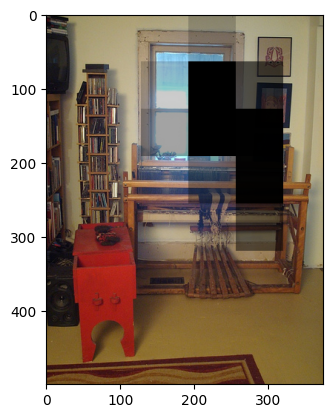

In [24]:
if __name__ == "__main__":
    # dataset = COCODatasetSegFirst(root="../Data/COCO17", train=True, len=1)
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

    policy.eval()
    policy.set_eps(eps_test)
    env = TimeLimit(Environment(dataloader), 200)
    collector = ts.data.Collector(policy, env, exploration_noise=True)
    collector.collect(n_episode=2, render=1 / 35)